In [1]:
import numpy as np
import sparrowpy as sp
from sparrowpy import image_source as ims


import pyfar as pf
import matplotlib.pyplot as plt
%matplotlib ipympl
from datetime import datetime

fast rad

In [2]:
# Define parameters
X = 3
Y = 3
Z = 3
patch_size = 1
ir_length_s = 2
sampling_rate = 1000
max_order_k = 5
speed_of_sound = 346.18
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [0.5, 0.5, 0.5]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [0.25, 0.25, 0.25]


# create object
radiosity_fast = sp.DRadiosityFast.from_polygon(walls, patch_size)

# create directional scattering data (totally diffuse)
sources = pf.samplings.sph_gaussian(sh_order=5)
sources = sources[sources.z>=0]
print(f'number of sources {sources.csize}')
receivers = pf.samplings.sph_gaussian(sh_order=5)
receivers = receivers[receivers.z>=0]
print(f'number of receivers {receivers.csize}')
frequencies = np.array([500])
data_scattering = sp.brdf.create_from_scattering(
    sources, receivers,
    pf.FrequencyData(np.zeros_like(frequencies), frequencies))

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)

# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))


number of sources 36
number of receivers 36


c:\Users\heimes\AppData\Local\miniconda3\envs\sparapy\Lib\site-packages\pyfar\samplings\samplings.py:300: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  warnings.warn((
c:\Users\heimes\AppData\Local\miniconda3\envs\sparapy\Lib\site-packages\pyfar\classes\coordinates.py:136: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  warnings.warn((
c:\Users\heimes\AppData\Local\miniconda3\envs\sparapy\Lib\site-packages\pyfar\classes\coordinates.py:166: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((
C:\Users\heimes\AppData\Local\Temp\ipykernel_14784\3685337642.py:35: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_scattering(


In [3]:
# calculate from factors including directivity and absorption
start = datetime.now()
radiosity_fast.bake_geometry(algorithm='order')
delta = (datetime.now() - start)
print(f"Time elapsed for bake_geometry: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

Time elapsed for bake_geometry: 0:00:16.669771


In [4]:
# initialize source energy at each patch
start = datetime.now()
radiosity_fast.init_source_energy(source_pos, algorithm='order')
delta = (datetime.now() - start)
print(f"Time elapsed for init_source_energy: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6


# gather energy at receiver
start = datetime.now()
ir_fast = radiosity_fast.calculate_energy_exchange_receiver(
    receiver_pos, speed_of_sound=speed_of_sound,
    histogram_time_resolution=1/sampling_rate, histogram_length=ir_length_s,
    algorithm='order', max_depth=max_order_k)
reverberation_fast = pf.Signal(ir_fast, sampling_rate=sampling_rate)
delta = (datetime.now() - start)
print(f"Time elapsed for calculate_energy_exchange_receiver: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

Time elapsed for init_source_energy: 0:00:05.420072
Time elapsed for calculate_energy_exchange_receiver: 0:00:07.083155


image source

In [5]:
MaxOrder = 5


RoomSizes = (3, 3, 3)
WallsHesse = ims.get_walls_hesse(*RoomSizes)


WallsR = 0.9
SourcePos = [0.50, 0.50, 0.50]




ISList_valid = ims.calculate_image_sources(WallsHesse, SourcePos, MaxOrder)


ReceiverPos = [0.25, 0.25, 0.25]
ISList_audible = ims.filter_image_sources(ISList_valid, WallsHesse, ReceiverPos)


impulse_response = ims.calculate_impulse_response(ISList_audible, WallsR, ReceiverPos)
energy = np.square(impulse_response)
image_source = pf.Signal(energy, 10000)


compare

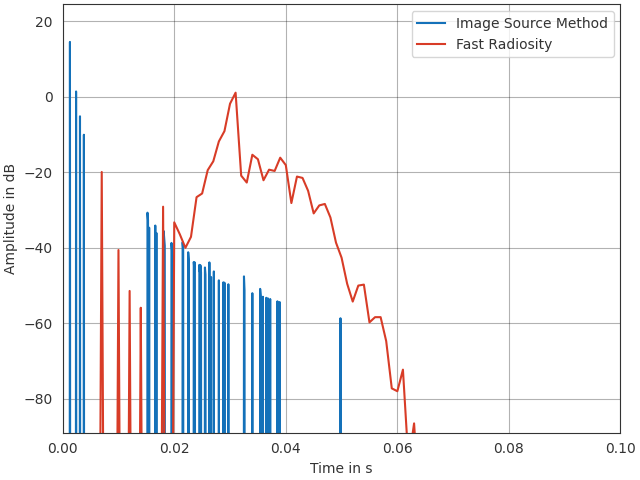

In [7]:
pf.plot.use()
plt.figure()

ax = pf.plot.time(image_source, dB=True, label="Image Source Method")
ax = pf.plot.time(reverberation_fast, dB=True, label="Fast Radiosity")

#title = title = f"Radiosity Order {k} Patch Size {patch_size} vs Image Source Order {MaxOrder}"
ax.legend(loc="upper right")
ax.set_xlim([0, 0.1])
#plt.title(title)
plt.show()